In [385]:
import os
import pandas as pd
from pandas.tools.plotting import table
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
from matplotlib import pyplot as plt
from matplotlib import gridspec

import scipy

import datetime
from collections import OrderedDict

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, RBF, ConstantKernel as C
np.random.seed(1)
%matplotlib inline

In [199]:
class Parser:
    def __init__(self):
        index = pd.date_range(datetime.datetime(1983,1,1),datetime.datetime(2017,12,1), freq='MS')
        Dummy = np.zeros(shape=index.shape)
        data={'Dummy':Dummy}
        self.Data = pd.DataFrame(index=index,data=data)
    def Read_Meta(self,Path,thresh=0):
        self.thresh=thresh
        Names = []
        Start = []
        End = []
        Lat = []
        Long = []
        Break = []
        File = []
        offset = []
        for Dir,subdir,files in os.walk(Path):
            for file in files:
                Temp = open(Dir+file).readlines()
                i = 0
                for line in Temp:
                    if line [0]!= 'C':
                        Break.append(i-3)
                        File.append(file)
                        break
                    else:
                        if "STATION NAME: " in line:
                            Names.append(line.split(': ')[1].split(' \n')[0])
                        elif "COVERING PERIOD: " in line:
                            Cov = line.split(': ')[1].split('\n')[0].split(' ')
                            Start.append(Cov[0])
                            End.append(Cov[1])
                        elif "LATITUDE: " in line:
                            Lat.append(float(line.split(': ')[1].split('\n')[0]))
                        elif "LONGITUDE: " in line:
                            Long.append(float(line.split(': ')[1].split('\n')[0]))
                        elif "MEASUREMENT UNIT: " in line:
                            if "ppm" in line:
                                offset.append(1000)
                            else:
                                offset.append(1)
                        i +=1
        Meta = {'Name':Names,'Start':Start,'End':End,'Lat':Lat,'Long':Long,'Break':Break,'File':File,'Offset':offset}
        Meta = pd.DataFrame(data=Meta)
        Meta['Start'] = pd.to_datetime(Meta['Start'])
        Meta['End'] = pd.to_datetime(Meta['End'])
        Meta['Span'] = Meta['End']-Meta['Start']
        self.Meta=Meta
        
    def Read_Data(self,Dir,min_years=1):
        self.keep = []
        for Site in self.Meta['Name'].unique():
            Var = Site
            Var2=Var
            Recs=self.Meta.loc[self.Meta['Name']==Site].sort_values(by='Span',ascending=False)
            i = 0
            for file in Recs['File']:
                if i != 0:
                    Var=Var+'_'+str(i)
                skip = Recs['Break'].loc[Recs['File']==file].values[0]
                df = pd.read_table(Dir+file,skiprows = skip,names=["DATE","TIME","dummy1","dummy2",Var,"ND","SD","F","CS","REM"],
                                   delim_whitespace=True)
                df['date']=pd.to_datetime(df['DATE'])
                df = df.set_index(df['date'])
                try:
                    df = df.resample('MS').ffill().reindex(pd.date_range(df.index[0],df.index[-1],freq='MS'))
                    if ((df.index.max()-df.index.min()).days)>=(min_years*365):
                        offset = Recs['Offset'].loc[Recs['File']==file].values[0]
                        if offset != 1:
                            df[Var] = df[Var]*offset
                        self.Data = pd.merge(self.Data,df[Var].to_frame(),left_index=True,right_index=True,how='outer')
                        if i == 0:
                            self.keep.append(file)
                except:
                    print('Error, Dropping File: '+file)
                i +=1
                Var=Var2
        
        self.Data.drop('Dummy',inplace=True,axis=1)
        self.Duplicates()
        self.Data[self.Data<self.thresh]=np.nan
        self.Aggregate()
        self.Profile()
        
    def Duplicates(self):
        for var in self.Data:
            if '_' in var:
                Site = var.split('_')
                self.Data.loc[self.Data[Site[0]]==np.nan,[Site[0]]]=self.Data[Site[0]+'_'+Site[1]]
                self.Data.drop(var,inplace=True,axis=1)
        self.Meta = self.Meta[self.Meta['File'].isin(self.keep)]
        self.Meta.reset_index()
        self.Meta.set_index('Name',drop=True,inplace=True)
        
    def Aggregate(self):
        self.Yearly = self.Data.resample('A').mean()
        self.Yearly_std = self.Data.resample('A').std()
        self.Yearly_ct = self.Data.resample('A').count()
        self.Monthly = self.Data.groupby(self.Data.index.month).mean()
        self.Monthly_std = self.Data.groupby(self.Data.index.month).std()
        self.Monthly_ct = self.Data.groupby(self.Data.index.month).count()
        
        
    def Profile(self):
        Data = self.Data
        Meta = self.Meta
        Meta = Meta.sort_values(by='Lat',axis=0)
        Lat_Profile = np.empty(shape = (len(Meta)),dtype=[('Lat', np.float64), ('mean', np.float64), 
                                                          ('std', np.float64),('SE', np.float64)])
        Lat_Profile_yr = np.empty(shape = (len(Meta),self.Yearly.shape[0]),dtype=[('Lat', np.float64), ('mean', np.float64), 
                                                          ('std', np.float64),('SE', np.float64)])
        Lat_Profile_mo = np.empty(shape = (len(Meta),self.Monthly.shape[0]),dtype=[('Lat', np.float64), ('mean', np.float64), 
                                                          ('std', np.float64),('SE', np.float64)])
        for i,station in enumerate(Meta.index):
            Lat_Profile['Lat'][i]=Meta.loc[station]['Lat']
            Lat_Profile['mean'][i]=np.nanmean(Data[station])
            Lat_Profile['std'][i]=np.nanstd(Data[station])
            Lat_Profile['SE'][i]=np.nanstd(Data[station])/(np.count_nonzero(np.isnan(Data[station]))**.5)


            Lat_Profile_yr['Lat'][i,:]=Meta.loc[station]['Lat']
            Lat_Profile_yr['mean'][i,:]=self.Yearly[station].values
            Lat_Profile_yr['std'][i,:]=self.Yearly_std[station].values
            Lat_Profile_yr['SE'][i,:]=self.Yearly_std[station].values/self.Yearly_ct[station].values

            Lat_Profile_mo['Lat'][i,:]=Meta.loc[station]['Lat']
            Lat_Profile_mo['mean'][i,:]=self.Monthly[station].values
            Lat_Profile_mo['std'][i,:]=self.Monthly_std[station].values
            Lat_Profile_mo['SE'][i,:]=self.Monthly_std[station].values/self.Monthly_ct[station].values
        self.Lat_Profile = Lat_Profile
        self.Lat_Profile_yr = Lat_Profile_yr
        self.Lat_Profile_mo = Lat_Profile_mo
        self.Months = np.arange(1,13,1)
        self.Years=np.arange(1983,2017,1)#self.Yearly.loc[self.Yearly.count(axis=1)>3].index.year.values

CH4_13 = Parser()
CH4_13.Read_Meta('C:/Users/wesle/CompsProj/13ch4/monthly/',thresh=-1000)
CH4_13.Read_Data('C:/Users/wesle/CompsProj/13ch4/monthly/')
    
CH4 = Parser()
CH4.Read_Meta('C:/Users/wesle/CompsProj/ch4/monthly/')
CH4.Read_Data('C:/Users/wesle/CompsProj/ch4/monthly/',min_years=5)



LinregressResult(slope=-0.0031512503946325115, intercept=-41.491036334820862, rvalue=-0.94690118414569724, pvalue=8.9293999907437251e-08, stderr=0.00029677065138136439)
(-287.44115925158241, -11739.268885543152, -374.24140919139609, -188.9230170508998)


,Station,Lattitude,CH4 ppb,Delta 13C,r,r^2,p
0,Alert,82.45,1864,-47.407,-0.57,0.32,0.054
1,Zeppelinfjellet (Ny-Alesund),78.9,1880,-47.457,-0.94,0.88,0.064
2,Barrow,71.32,1872,-47.468,-0.63,0.4,0.0152
3,Cold Bay,55.2,1876,-47.524,0.76,0.58,0.2401
4,Mace Head,53.33,1852,-47.331,-0.43,0.19,0.1411
5,Niwot Ridge (T-van),40.053,1829,-47.161,-0.56,0.32,0.0365
6,Terceira Island,38.77,1838,-47.235,-0.22,0.05,0.4905
7,Tae-ahn Peninsula,36.72,1895,-47.354,-0.77,0.6,0.0031
8,Mt. Waliguan,36.28,1842,-47.255,-0.54,0.29,0.0875
9,Mauna Loa,19.539,1793,-47.115,-0.65,0.43,0.0114


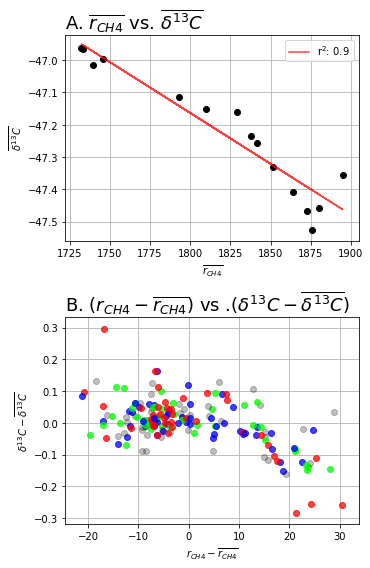

In [658]:
plt.figure()

def highlight_max(p):
    '''
    highlight the maximum in a Series yellow.
    '''
#     is_max = s == s.max()
    if p  < 0.05:
        Ret = 'background-color: yellow' 
    else:
        Ret = ''
    return Ret

def color_negative_red(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for negative
    strings, black otherwise.
    """
    if val < 0.01:#0.01:
        color = 'red' 
    elif val < 0.05:#0.05:
        color = 'green'
    elif val < 0.1:#0.05:
        color = 'blue'
    else: color = 'black'
    return 'color: %s' % color

fig,ax = plt.subplots(2,1, figsize=(5.25,8))
D = pd.DataFrame(index=np.arange(0,15,1),columns=['Station','Lattitude','CH4 ppb','Delta 13C','r','r^2','p'])
X = []
y = []
for i,Station in enumerate(CH4_13.Meta.index):
    ch4 = CH4.Yearly[Station].loc[np.isnan(CH4_13.Yearly[Station])==False]
    ch4_13 = CH4_13.Yearly[Station].loc[np.isnan(CH4_13.Yearly[Station])==False]
    s = scipy.stats.linregress(ch4,ch4_13)
    D.iloc[i] = [Station,CH4_13.Meta['Lat'][Station],ch4.mean(),ch4_13.mean(),s[2],0,s[3]]
    
    ax[0].scatter(CH4.Yearly[Station].loc[np.isnan(CH4_13.Yearly[Station])==False].mean(),
                      CH4_13.Yearly[Station].mean(),
                      color = 'black')
    if s[3]< .01:
        ax[1].scatter(ch4-ch4.mean(),ch4_13-ch4_13.mean(),color=Red,label='p < 0.01')
    elif s[3]< .05:
        ax[1].scatter(ch4-ch4.mean(),ch4_13-ch4_13.mean(),color=Green,label='p < 0.05')
    elif s[3]< .1:
        ax[1].scatter(ch4-ch4.mean(),ch4_13-ch4_13.mean(),color=Blue,label='p < 0.1')
    else:
        ax[1].scatter(ch4-ch4.mean(),ch4_13-ch4_13.mean(),color=LightGrey)
        
        
    X.append(ch4.mean())
    y.append(ch4_13.mean())
    TS = scipy.stats.mstats.theilslopes(ch4,ch4_13,alpha=0.90)
    
    ax[0].set_title('A. ${\overline{r_{CH4}}}$ vs. ${\overline{\delta^{13} C}}$',fontsize=TitleFont,loc='left')
    ax[1].set_title('B. $({r_{CH4}}- \overline{r_{CH4}})$ vs .$({\delta^{13} C}- \overline{\delta^{13} C})$',fontsize=TitleFont,loc='left')
    ax[0].set_ylabel('${\overline{\delta^{13} C}}$')
    ax[0].set_xlabel('${\overline{r_{CH4}}}$')
    ax[1].set_ylabel('${\delta^{13} C}- \overline{\delta^{13} C}$')
    ax[1].set_xlabel('${r_{CH4}}- \overline{r_{CH4}}$')
    
    plt.tight_layout()
#     print(Station)
#     print(TS)
#     plt.xlim(-100,100)
        
# ax[1].plot(Topx,Topy,color=Red)#,linewidth=3)

    
X = np.asanyarray(X)
y = np.asanyarray(y) 
s = scipy.stats.linregress(X,y)
TS = scipy.stats.mstats.theilslopes(X,y,alpha=0.95)

ax[0].plot(X,X*s[0]+s[1],label = 'r$^2$: '+str(np.round(s[2]**2,2)),color=Red)
ax[0].legend()
# ax[1].set_yscale('symlog')
# ax[1].set_xscale('symlog')

ax[0].grid()
ax[1].grid()
plt.savefig('C:\\Users\\wesle\\CompsProj\\Figures/fig7.png',dpi=500)

print(s)
print(TS)


for col in ['CH4 ppb','Delta 13C','r','p']:
    D[col] = pd.to_numeric(D[col], errors='coerce')
    
D['r^2'] = D['r']**2
D.sort_values(by='Lattitude',ascending=False,inplace=True)
D = D.round({'CH4 ppb':0,'Delta 13C':3,'r':2,'r^2':2,'p':4})
# D.drop('p',inplace=True,axis=1)
D.reset_index(inplace=True,drop=True)
D.style.applymap(color_negative_red,subset=['p'])

# D
# D.to_html('Table.html')
# D.to_html('Table.html')
# plt.legend()

In [12]:
def Lat_Split(Meta):
    Arctic = (Meta.index[Meta['Lat']>66.5]).values
    Mid_Lats_N = (Meta.index[(Meta['Lat']<66.5)&(Meta['Lat']>23.5)]).values
    Tropics = (Meta.index[(Meta['Lat']<23.5)&(Meta['Lat']>-23.5)]).values
    Mid_Lats_S = (Meta.index[(Meta['Lat']<-23.5)&(Meta['Lat']>-66.6)]).values
    Antarctic = (Meta.index[Meta['Lat']<-66.5]).values
    return(Arctic,Mid_Lats_N,Tropics,Mid_Lats_S,Antarctic)


def Label_Duplicates(ax):
    handles, labels = ax.get_legend_handles_labels()
    handle_list, label_list = [], []
    for handle, label in zip(handles, labels):
        if label not in label_list:
            handle_list.append(handle)
            label_list.append(label)
    return(handle_list,label_list)

def Error_Bar_Plot(Data,Columns,colors,labels,title):
    fig,ax=plt.subplots(1,1,figsize=(18,14))
    for col,color,label in zip(Columns,colors,labels):
        if len(col) > 1: 
            plt.errorbar(Data[col[0]].index,Data[col].mean(axis=1),yerr=Data[col].std(axis=1)/(Data[col].count(axis=1)**.5),
                     color=color,label=label+'$\pm$ 1 SE',capsize=10)
        else:
            plt.plot(Data[col[0]].index,Data[col].mean(axis=1),color=color,label=label)
    handle_list, label_list=Label_Duplicates(ax)
    plt.legend(handle_list, label_list)
    plt.title(title,fontsize =22)    
    plt.show()
    


# Ploting Parametres

In [579]:
TitleFont=18
AxisLabelFont = 12
LegendFont = 10

Red = (1,0,0,.75)
Green = (0,1,0,.75)
Blue = (0,0,1,.75)
LightGrey = (0,0,0,.25)

# Figure 2 - Distribution of study sites

[ 1.039   1.0065  1.0175]


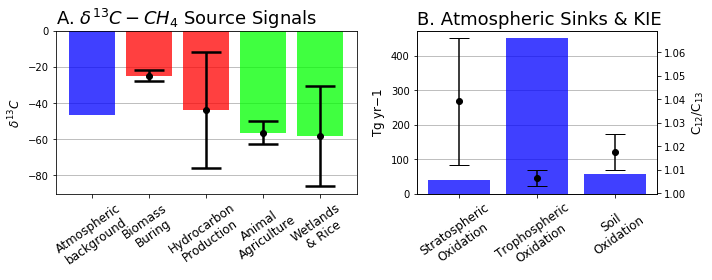

In [632]:
def Intro_Plot():
    plt.rcParams['axes.axisbelow'] = True
    
    fig = plt.figure(figsize=(10,4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[5, 4]) 

## Plot 1

    ax2 = plt.subplot(gs[0,1])
    ax3 = plt.subplot(gs[0,0])

    Sinks = [40,450,58]
    Index = np.arange(0,len(Sinks))
    Sinks = np.asanyarray(Sinks)
    System = ['Stratospheric\nOxidation','Trophospheric\nOxidation','Soil\nOxidation']
    System = np.asanyarray(System)
    Color = [Blue,Blue,Green]
    barlist = ax2.bar(Index,Sinks,color = Blue)
    plt.sca(ax2)
    plt.xticks(Index, System,fontsize=AxisLabelFont,rotation = 35)
    
    Sinks_High = [1.066,1.010,1.025]
    Sinks_Low = [1.012,1.003,1.010]
    Index = np.arange(0,len(Sinks_High))
    Sinks_Low = np.asanyarray(Sinks_Low)
    Sinks_Hight = np.asanyarray(Sinks_High)
    Sinks_Mid = (Sinks_High+Sinks_Low)/2
    ax2.set_ylabel('Tg yr${-1}$',fontsize = AxisLabelFont)
    ax2_2 = ax2.twinx()
    ax2_2.errorbar(Index,Sinks_Mid,yerr=(Sinks_High-Sinks_Low)/2,fmt='o',color='black',capsize=10)
    print(Sinks_Mid)#-(Sinks_High-Sinks_Low))
    ax2_2.set_ylabel('C$_{12}$/C$_{13}$',fontsize = AxisLabelFont)
    ax2.yaxis.grid(zorder=0)
    plt.sca(ax2_2)

## Plot 3
    
    Sinks_High = [-47,-22,-12,-50,-31]
    Sinks_Low = [-47,-28,-76,-63,-86]
    Index = np.arange(0,len(Sinks_High))
    Sinks_Low = np.asanyarray(Sinks_Low)
    Sinks_High = np.asanyarray(Sinks_High)
    Sinks_Mid = (Sinks_High+Sinks_Low)/2
    System = ['Atmospheric\nbackground','Biomass\nBuring','Hydrocarbon\nProduction','Animal\nAgriculture','Wetlands\n& Rice']
    System = np.asanyarray(System)
    Color = [Blue,Red,Red,Green,Green]
    ax3.yaxis.grid(zorder=0)
    plt.sca(ax3)
    for pos, y, err, color in zip(Index, Sinks_Mid, (Sinks_High-Sinks_Low)/2, Color):
        barlist = ax3.bar(pos,y,color=color)
        if pos != 0:
            ax3.errorbar(pos, y, err, lw=2.5, capsize=15, capthick=2.5, color='black',fmt='o')
    plt.xticks(Index, System,fontsize=AxisLabelFont,rotation = 35)
    ax3.set_ylabel('${\delta^{13} C}$',fontsize = AxisLabelFont)
    
    ax2.set_title('B. Atmospheric Sinks & KIE', loc ='left',fontsize = TitleFont)
    ax3.set_title('A. ${\delta^{13} C - CH_{4}}$ Source Signals', loc ='left',fontsize = TitleFont)
    fig.tight_layout()
    plt.savefig('C:\\Users\\wesle\\CompsProj\\Figures/fig1.png',dpi=500)
    
Intro_Plot()

C:\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


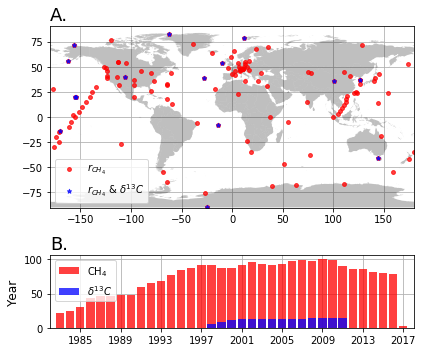

In [629]:
World = gpd.read_file('TM_WORLD_BORDERS-0.3.shp')

geometry = [Point(xy) for xy in zip(CH4.Meta.Long, CH4.Meta.Lat)]
df = CH4.Meta.drop(['Long', 'Lat'], axis=1)
crs = {'init': 'epsg:4326'}
CH4_gpd = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)

geometry = [Point(xy) for xy in zip(CH4_13.Meta.Long, CH4_13.Meta.Lat)]
df = CH4_13.Meta.drop(['Long', 'Lat'], axis=1)
crs = {'init': 'epsg:4326'}
CH4_13_gpd = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)


# fig, ((ax1, ax2)) = plt.subplots(nrows=2, ncols=1, figsize=(12, 16))

fig = plt.figure(figsize=(6, 5)) 
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1.2]) 

ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[1])

World.plot(ax=ax1,color=LightGrey)
CH4_gpd.plot(ax=ax1,color = Red,markersize=15,label='$r_{CH_4}$')
CH4_13_gpd.plot(ax=ax1,color = Blue,marker = '*',markersize = 20,label='$r_{CH_4}$ & ${\delta^{13} C}$')

handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels,loc=3,fontsize = LegendFont)
ax1.set_ylim(-90.1,90.1)
ax1.set_xlim(-180.1,180.1)
ax1.set_title('A.',loc='left',fontsize=TitleFont)

ax2.bar(CH4.Yearly.count(axis=1).index-1,CH4.Yearly.count(axis=1),width=300,color=Red,label='CH$_4$')
ax2.bar(CH4_13.Yearly.count(axis=1).index-1,CH4_13.Yearly.count(axis=1)
        ,width=300,color=Blue,label='${\delta^{13} C}$')
ax2.set_xlim('1982-01-01','2018-1-31')
ax2.set_title('B.',loc='left',fontsize=TitleFont)
ax2.set_ylabel('Number of\nStations',fontsize = AxisLabelFont)
ax2.set_ylabel('Year',fontsize = AxisLabelFont)
ax2.xaxis_date()
ax1.grid()
ax2.grid()

# print(CH4_13.Meta.sort_values('Lat'))

plt.legend(fontsize = LegendFont)
# plt.suptitle('$r_{CH_4}$ and ${\delta^{13} C-CH_4}$ Observations',y=.93,fontsize=22)
plt.tight_layout()
plt.savefig('C:\\Users\\wesle\\CompsProj\\Figures/fig2.png',dpi=500)
plt.show()

# Figure 2 - Global trend in CH$_4$ Concentrations

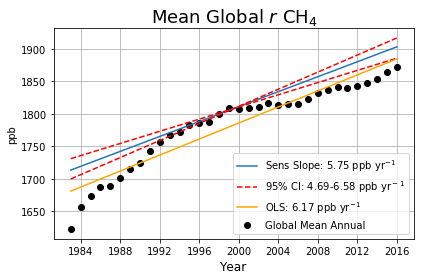

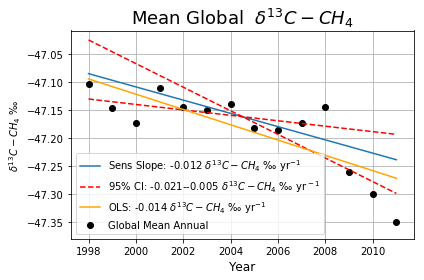

In [659]:
def Slope_Analysis(Data,Period,loc,r,Title,Unit,size,SaveName):
    MeanAnnual = Data.mean(axis=1).loc[Period[0]:Period[1]].resample('AS').mean()
    Line = np.arange(0,MeanAnnual.shape[0])
    Line = Line-Line[-1]/2
    m,b = np.polyfit(Line,MeanAnnual.values,1)
    Linear_Trend = m*Line+b

    TS = scipy.stats.mstats.theilslopes(MeanAnnual.values,Line,alpha=0.95)
    Mean_TS = TS[0]*Line + TS[1]
    Lower_TS = TS[2]*Line + TS[1]
    Upper_TS = TS[3]*Line + TS[1]
    plt.figure(figsize = size)
    plt.scatter(MeanAnnual.index,MeanAnnual,label = 'Global Mean Annual',color = 'black')
    plt.plot(MeanAnnual.index,Mean_TS,label = 'Sens Slope: '+str(np.round(TS[0],r))+' '+Unit+' yr$^{-1}$')
    plt.plot(MeanAnnual.index,Lower_TS,
             label = '95% CI: '+str(np.round(TS[2],r))+'-'+str(np.round(TS[3],r))+' '+Unit+' yr$^-$$^1$',
             color = 'red',linestyle = '--')
    plt.plot(MeanAnnual.index,Upper_TS,color = 'red',linestyle = '--')
    plt.plot(MeanAnnual.index,Linear_Trend,color='orange', label='OLS: '+str(np.round(m,r))+' '+Unit+' yr$^{-1}$')
    plt.title(Title,fontsize = TitleFont)
    plt.ylabel(Unit) 
    plt.xlabel('Year',fontsize = AxisLabelFont)
    plt.legend(fontsize = LegendFont,loc=loc)
    plt.grid()
    plt.tight_layout()
    plt.savefig(SaveName,dpi=500)
    plt.show()
Title = 'Mean Global $r$ CH$_4$'
size = (6,4)
Slope_Analysis(CH4.Data,Period = ['1983-01-01','2016-12-31'],loc=4,r=2,Title=Title,Unit='ppb',size = size,
             SaveName='C:\\Users\\wesle\\CompsProj\\Figures/fig3.png')


Title = 'Mean Global  ${\delta^{13} C - CH_{4}}$'
Slope_Analysis(CH4_13.Data,Period = ['1998-01-01','2011-12-31'],loc=3,r=3,
              Title=Title,Unit='${\delta^{13} C-CH_4}$ ‰',size = size,
             SaveName='C:\\Users\\wesle\\CompsProj\\Figures/fig4.png')


In [9]:
Arctic,Mid_Lats_N,Tropics,Mid_Lats_S,Antarctic=Lat_Split(CH4.Meta)
Arctic_13,Mid_Lats_N_13,Tropics_13,Mid_Lats_S_13,Antarctic_13=Lat_Split(CH4_13.Meta)

Lat_Profile_13,Lat_Profile_yr_13 = Profile(CH4_13)
Lat_Profile,Lat_Profile_yr = Profile(CH4)

# Gaussian Process Regresion
    - Interpolation, Hyperparameter Optimization, Visualization

In [655]:
Month_Labels = np.asanyarray(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])


def Interp(Lat_Profile,kernel,alpha=None,ax=None,color=None,Label=None,plot=True):
    X = Lat_Profile['Lat'].reshape(-1,1)
    x = np.arange(-90,90.1,1).reshape(-1,1)
    y = Lat_Profile['mean']
    dy = Lat_Profile['std']*1.96
    if alpha==None:
        alpha = Lat_Profile['mean'].std()
    gp = GaussianProcessRegressor(kernel=kernel, alpha=alpha,
                                  n_restarts_optimizer=25,normalize_y =True)
    gp.fit(X, y)
    y_pred, sigma = gp.predict(x, return_std=True)
    if plot == True:
        fig,ax = plt.subplots()
        ax.errorbar(y,X.ravel(), xerr=dy, fmt='r.', markersize=10,alpha = 0.5)
        ax.plot(y_pred,x, color=color, label=Label)
        ax.fill(np.concatenate([y_pred - 1.9600 * sigma,(y_pred + 1.9600 * sigma)[::-1]]),
                np.concatenate([x, x[::-1]]),alpha=.5, fc='None', ec=color)

        ax.grid()
#     else:
    return(x,y_pred,sigma)

def Kernel_Optimisation(Lat_Profile,Kernel,alpha=None):
    fig,ax = plt.subplots(figsize=(6,6))
    Color = [Red,Green,Blue]
    Lable = ['K1','K2','K3']
    for kernel,color,L in zip(Kernel,Color,Lable):
        Lat,pred,sigma=Interp(Lat_Profile,kernel,alpha,ax,color,L)
    plt.legend()
    
def Plot_Profile(Lat_Profile,pred,sigma,Surface,X,Y,MonthlySurface,Lat,Months,Kwargs,ax4y,ax5y):#,ax1_xlim=None,ax1_loc=None,ax2_zlim=None,azim=None):
    fig = plt.figure(figsize=Kwargs['size'])
    gs = gridspec.GridSpec(3, 2, width_ratios=[1.5, 3], height_ratios=[3, 1.75,1.25]) 

    ax1 = plt.subplot(gs[0,0])
    ax2 = plt.subplot(gs[0,1],projection='3d')
    ax3 = plt.subplot(gs[1,1])
    ax4 = plt.subplot(gs[1,0])
    ax5 = plt.subplot(gs[2,:])

    ax1.errorbar(Lat_Profile['mean'],Lat_Profile['Lat'], xerr=Lat_Profile['SE']*1.96, fmt='r.', markersize=10, 
                 label='Obs\n[95% CI]',alpha = 0.5)
    ax1.fill(np.concatenate([pred - 1.9600 * sigma,(pred + 1.9600 * sigma)[::-1]]),
            np.concatenate([Lat, Lat[::-1]]),alpha=.5, fc='b', ec='None', label='95% CI')
    ax1.plot(pred,Lat, 'b-', label='GPR fit')
    ax1.set_xlabel(Kwargs['ax1_xlabel'],fontsize = AxisLabelFont)
    ax1.set_ylabel('Lattitude$\circ$',fontsize = AxisLabelFont)
    ax1.legend(loc=Kwargs['ax1_loc'],fontsize=LegendFont)
    
    ax1.set_title('A. Lattitudinal Profile',fontsize = TitleFont,loc='left')
    ax1.set_xlim(Kwargs['ax1_xlim'][0],Kwargs['ax1_xlim'][1])
    ax1.set_ylim(-91,91)
    ax1.grid()
    
    
    surf = ax2.plot_surface(X, Y, Surface, cmap=cm.jet,linewidth=1, antialiased=False)
    ax2.view_init(azim=Kwargs['azim'])
    ax2.set_title('B. Annual Progression',loc='left',fontsize=TitleFont)
    ax2.set_zlim(Kwargs['ax2_zlim'][0],Kwargs['ax2_zlim'][1])
    fig.colorbar(surf, shrink=0.5, aspect=5,ax=ax2,label=Kwargs['Unit'])
    ax2.set_xlabel('Lattitude$\circ$', fontsize = AxisLabelFont)
    ax2.set_ylabel('Year', fontsize = AxisLabelFont)
    ax2.set_zlabel(Kwargs['Unit'], fontsize = AxisLabelFont)
    
    surf = ax3.imshow(MonthlySurface,cmap=cm.jet,aspect='auto')
#     ax = plt.sca(ax3)
    ax3.set_xlim(0,180)
    ax3.set_ylim(0,11)
    
    pos = np.arange(0,6)
    ax3.set_yticks(pos*2)
    ax3.set_yticklabels(Month_Labels[pos*2])
    
    pos = np.arange(0,181,20)
    ax3.set_xticks(pos)
    ax3.set_xticklabels(pos-90)
    ax3.set_xlabel('Lattitude$\circ$', fontsize = AxisLabelFont)
    ax3.set_title('D. Monthly Cycle',loc='left',fontsize=TitleFont)
    ax3.grid()
    
    ax4.plot(ax4y,color=Blue)
    ax4.set_xlabel('Lattitude$\circ$', fontsize = AxisLabelFont)
    ax4.set_xticks(pos)
    ax4.set_xticklabels(pos-90)
    ax4.set_ylabel(Kwargs['ax1_xlabel'],fontsize = AxisLabelFont)
    ax4.set_title('C. Total Change',loc='left',fontsize=TitleFont)
    ax4.grid()
    
    ax5.plot(ax5y,color=Blue)
    ax5.set_xlabel('Lattitude$\circ$', fontsize = AxisLabelFont)
    ax5.set_xticks(pos)
    ax5.set_xticklabels(pos-90)
    ax5.set_ylabel(Kwargs['ax1_xlabel'],fontsize = AxisLabelFont)
    ax5.set_title('E. Annual Amplitude',loc='left',fontsize=TitleFont)
    ax5.grid()
    
    fig.colorbar(surf, aspect=5,ax=ax3,label=Kwargs['Unit'])
#     divider = make_axes_locatable(ax3)
#     cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.tight_layout()
    plt.savefig(Kwargs['Save'],dpi=500)
    print('Minima: ',pred.min(),' at: ',Lat[np.where(pred==pred.min())])
    print('Maxima: ',pred.max(),' at: ',Lat[np.where(pred==pred.max())])
    
    
    
    plt.show()


# GPR - CH4

Overal Trend
113.285553831
140.200055527
Seasonal Aplitudes Trend
23.9155891008
46.3040450438
AmpMax
[21] 48.3010347486
AmpMin
[-10] 9.45868214944
Monthly Norm:  1782.66525107
yearly Norm:  1765.39697099
Minima:  1715.32601735  at:  [[-38.]]
Maxima:  1879.62885975  at:  [[ 56.]]


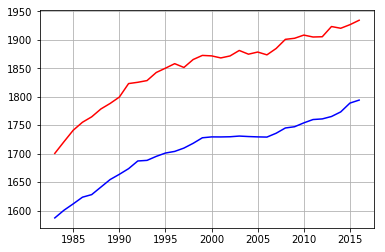

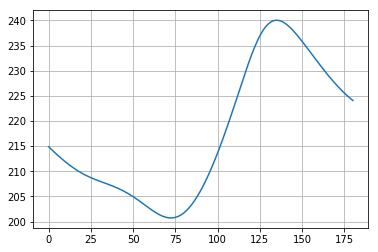

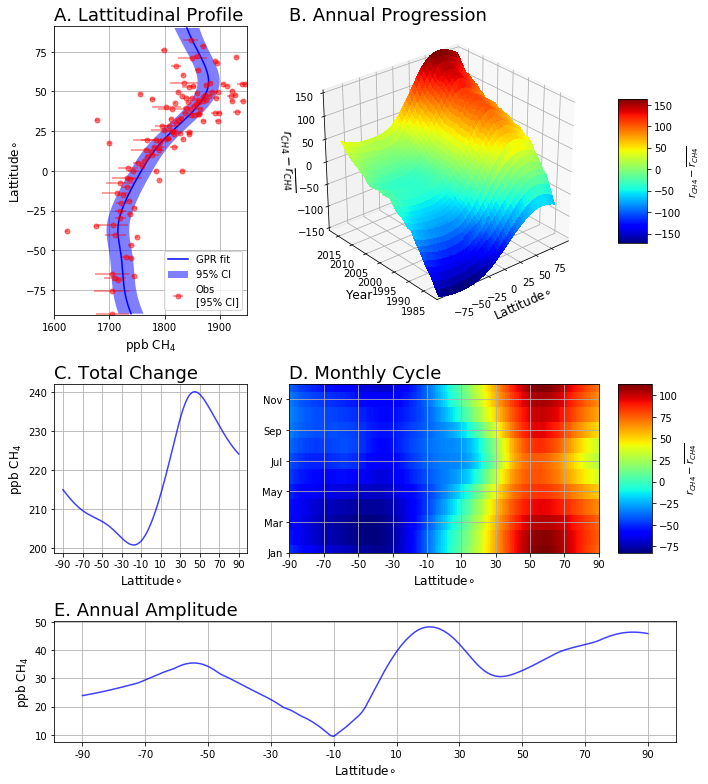

Overal Trend
0.579289367892
0.500586586021
Seasonal Aplitudes Trend
0.131741324518
0.477614894053
AmpMax
[90] 0.48946050942
AmpMin
[-8] 0.0585306113804
Monthly Norm:  -47.1346767119
yearly Norm:  -47.1265225144
Minima:  -47.4693168761  at:  [[ 90.]]
Maxima:  -46.9515851017  at:  [[-61.]]


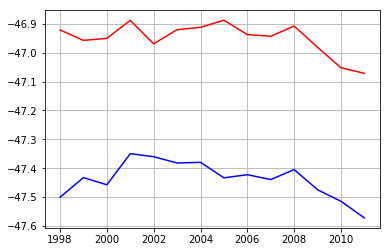

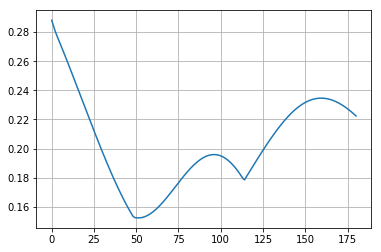

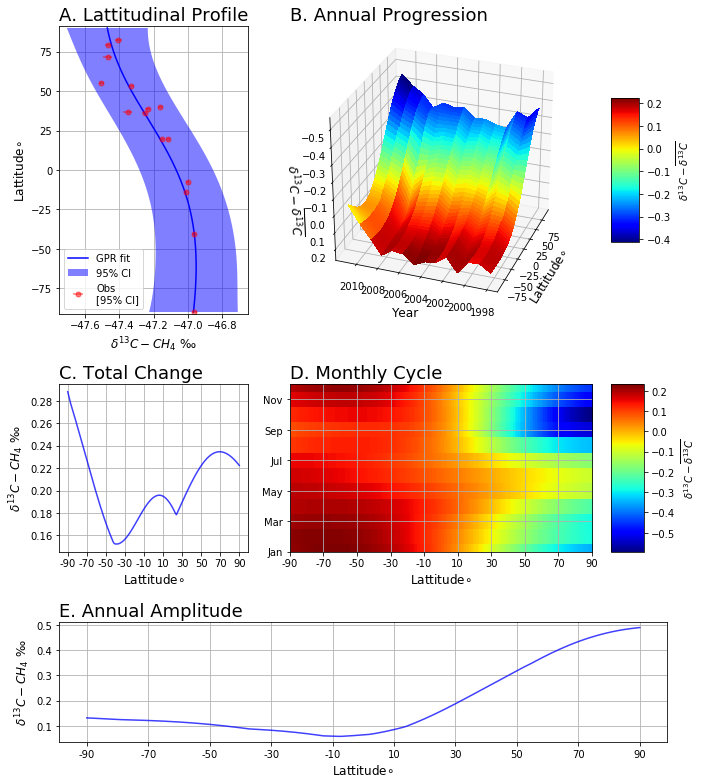

In [656]:
## Addded profile to main class
def GPR_Profile(Data,Kernel,Kwargs,Norm = False):
    Monthly = []
    for mo in (Data.Months-1):
        key = np.where(np.isnan(Data.Lat_Profile_mo['std'][:,mo])==False)
        if len(key[0]) > 1: 
            Lat,pred,sigma = Interp(Data.Lat_Profile_mo[key[0],mo],Kernel,alpha=0,plot=False)
            Monthly.append(pred)
    MonthlySurface=np.asanyarray(Monthly)
    X_mo,Y_mo = np.meshgrid(Lat,Data.Months)

    Yearly = []
    Yr = []
    for year,yr in  enumerate(Data.Years):
        key = np.where(np.isnan(Data.Lat_Profile_yr['std'][:,year])==False)
        if len(key[0]) > 1:
            Lat,pred,sigma = Interp(Data.Lat_Profile_yr[key[0],year],Kernel,alpha=0,plot=False)
            Yearly.append(pred)
            Yr.append(yr)
    YearlySurface=np.asanyarray(Yearly)
    Yr=np.asanyarray(Yr)
    X_yr,Y_yr = np.meshgrid(Lat,Yr)
    Lat,Mean,sigma = Interp(Data.Lat_Profile,Kernel,alpha=0,plot=False)
    
    print('Overal Trend')
    print(YearlySurface[0,:].max()-YearlySurface[0,:].min())
    print(YearlySurface[-1,:].max()-YearlySurface[-1,:].min())
    
    
    LatMin = []
    LatMax = []
    Min = []
    Max = []
    yrz = []
    for i in range(YearlySurface.shape[0]):
        if YearlySurface.shape[0]> 20:
            yrz.append(i+1983)
        else:
            yrz.append(i+1998)
        LatMin.append(np.where(YearlySurface[i,:] == YearlySurface[i,:].min())[0])
        LatMax.append(np.where(YearlySurface[i,:] == YearlySurface[i,:].max())[0])
        Min.append(YearlySurface[i,:].min())
        Max.append(YearlySurface[i,:].max())
        
    yrz = np.asanyarray(yrz)
    LatMax = np.asanyarray(LatMax)
    LatMin = np.asanyarray(LatMin)
    Max = np.asanyarray(Max)
    Min = np.asanyarray(Min)
    plt.figure()
    plt.plot(yrz,Max,color='red')
    plt.plot(yrz,Min,color='blue')
    plt.grid()
    
    
    print('Seasonal Aplitudes Trend')
    print(MonthlySurface[:,0].max()-MonthlySurface[:,0].min())
    print(MonthlySurface[:,90+83].max()-MonthlySurface[:,90+83].min())
    
    AnnualAmp = YearlySurface.max(axis=0) - YearlySurface.min(axis=0)
    
    
    
    MonthlyAmp = MonthlySurface.max(axis=0) - MonthlySurface.min(axis=0)
    print('AmpMax')
    print(np.where(MonthlyAmp == MonthlyAmp.max())[0]-90,MonthlyAmp.max())
    print('AmpMin')
    print(np.where(MonthlyAmp == MonthlyAmp.min())[0]-90,MonthlyAmp.min())
    
    plt.figure()
    plt.plot(AnnualAmp)
    plt.grid()
    
#     plt.figure()
#     plt.plot(yrz,LatMax,color='red')
#     plt.plot(yrz,LatMin,color='blue')
#     plt.grid()
    
    if Norm == True:
        print('Monthly Norm: ',MonthlySurface.mean())
        print('yearly Norm: ',YearlySurface.mean())
        YearlySurface=YearlySurface-YearlySurface.mean()
        MonthlySurface=MonthlySurface-MonthlySurface.mean()
        
    
    Plot_Profile(Data.Lat_Profile,Mean,sigma,YearlySurface-YearlySurface.mean(),
                 X_yr,Y_yr,MonthlySurface,Lat,Data.Months,Kwargs,AnnualAmp,MonthlyAmp)
    
Size = (10,11)
Kwargs={'ax1_loc':'lower right','ax1_xlim':[1600,1950],'azim':230,'ax2_zlim':[-150,150],
       'size':Size,'ax1_xlabel':'ppb CH$_4$','Unit':'${r_{CH4}}- \overline{r_{CH4}}$',
       'Save':'C:\\Users\\wesle\\CompsProj\\Figures/fig5.png'}
Kwargs_13={'ax1_loc':'lower left','ax1_xlim':[-47.75,-46.65],'azim':200,'ax2_zlim':[.25,-.55],
       'size':Size,'ax1_xlabel':'${\delta^{13} C-CH_4}$ ‰',
           'Unit':'${\delta^{13} C}- \overline{\delta^{13} C}$','Save':'C:\\Users\\wesle\\CompsProj\\Figures/fig6.png'}


# [-47.7,-46.65][-46.85,-47.6]
kernel_CH4 = C(1e0, (1e-2, 1e2))*Matern(1e1, (1e-4, 1e4),nu = 2.5)\
+ WhiteKernel(noise_level=1e0, noise_level_bounds=(1e-2, 1e2))
kernel_13CH4 = C(1e0, (1e-1, 1e1))*Matern(1e0, (1e-3, 1e3),nu = 2.5)\
+ WhiteKernel(noise_level=1e0, noise_level_bounds=(1e-2, 1e2))#, noise_level_bounds=(1e-5, 1e5))

GPR_Profile(CH4,kernel_CH4,Kwargs,Norm=True)
GPR_Profile(CH4_13,kernel_13CH4,Kwargs_13,Norm=True)


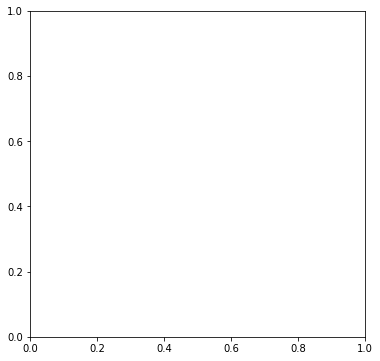

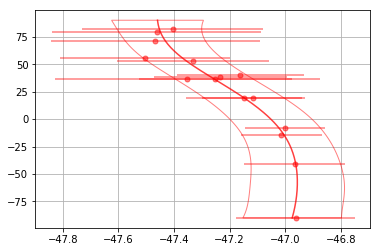

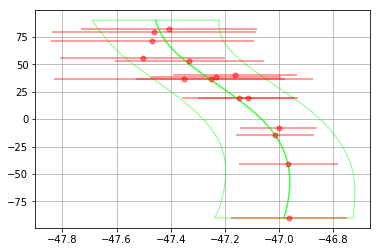

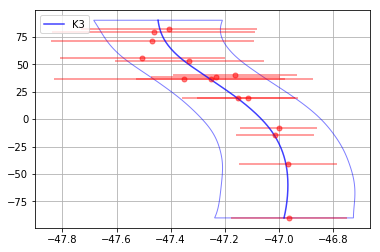

In [318]:
kernel_13CH4 = C(1e0, (1e-1, 1e1))*Matern(1e0, (1e-3, 1e3),nu = 2.5)
kernel_CH4 = C(1e0, (1e-2, 1e2))*Matern(1e1, (1e-4, 1e4),nu = 2.5)


kernel1 = C(1e0, (1e-2, 1e2))*Matern(1e1, (1e-4, 1e4),nu = 2.5)\
+ WhiteKernel(noise_level=1e0, noise_level_bounds=(1e-3, 1e3))

kernel2 = C(1e0, (1e-2, 1e2))*Matern(1e1, (1e-4, 1e4),nu = 2.5)\
+ WhiteKernel(noise_level=1e0, noise_level_bounds=(1e-2, 1e2))

kernel3 = C(1e0, (1e-2, 1e2))*Matern(1e1, (1e-4, 1e4),nu = 1.5)\
+ WhiteKernel(noise_level=1e0, noise_level_bounds=(1e-2, 1e2))

Kernel=[kernel1,kernel2,kernel3]
Kernel_Optimisation(CH4_13.Lat_Profile,Kernel,alpha=0)

# GPR - 13CH4

(126,)
(126,)


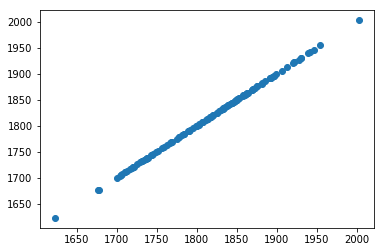

In [229]:
print(Lat_Profile.shape)
print(CH4.Lat_Profile.shape)
plt.scatter(CH4.Lat_Profile['mean'],Lat_Profile['mean'])

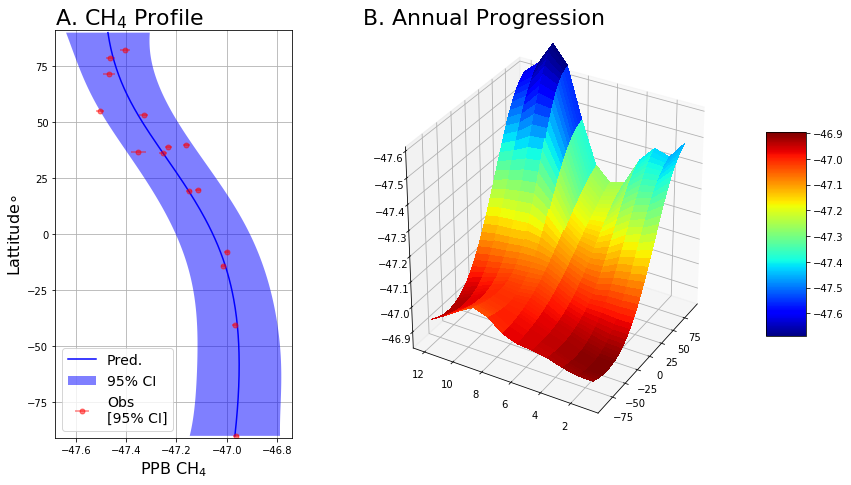

Minima:  -47.472715174  at:  [[ 90.]]  ${\circ}$
Maxima:  -46.9504928524  at:  [[-58.]]  ${\circ}$


In [17]:
Lat_Profile,Lat_Profile_yr,Lat_Profile_mo = Profile(CH4_13)

kernel_13CH4 = C(1e0, (1e-1, 1e1))*Matern(1e0, (1e-3, 1e3),nu = 2.5)\
+ WhiteKernel(noise_level=1e0, noise_level_bounds=(1e-5, 1e5))

Preds = []
for mo in range(Lat_Profile_mo.shape[1]):
    key = np.where(np.isnan(Lat_Profile_mo['std'][:,mo])==False)
    if len(key[0]) > 1: 
        Lat,pred,sigma = Interp(Lat_Profile_mo[key[0],mo],kernel_13CH4,alpha=0,plot=False)
        Preds.append(pred)

# for year in range(Lat_Profile_yr.shape[1]-1):
#     key = np.where(np.isnan(Lat_Profile_yr['std'][:,year])==False)
#     if len(key[0]) > 1: 
#         Lat,pred,sigma = Interp(Lat_Profile_yr[key[0],year],kernel_13CH4,alpha=0,plot=False)
#         Preds.append(pred)
Surface = np.asanyarray(Preds)
Year = np.arange(1998,2012,1)
Year = np.arange(1,13,1)
X,Y = np.meshgrid(Lat,Year)
Lat,pred,sigma = Interp(Lat_Profile,kernel_13CH4,alpha=0,plot=False)
Plot_Profile(Lat_Profile,pred,sigma,Surface,X,Y,Year,ax1_loc='lower left',ax2_zlim=[-46.85,-47.6],azim=210)

# Fractination example

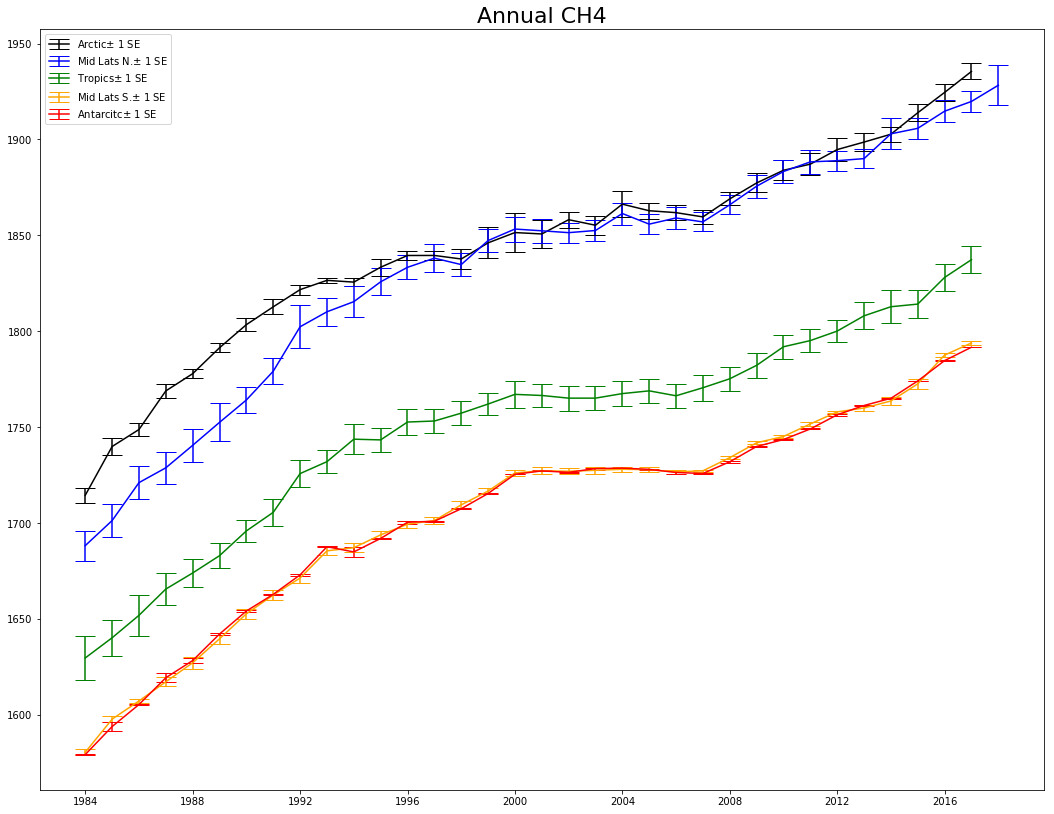

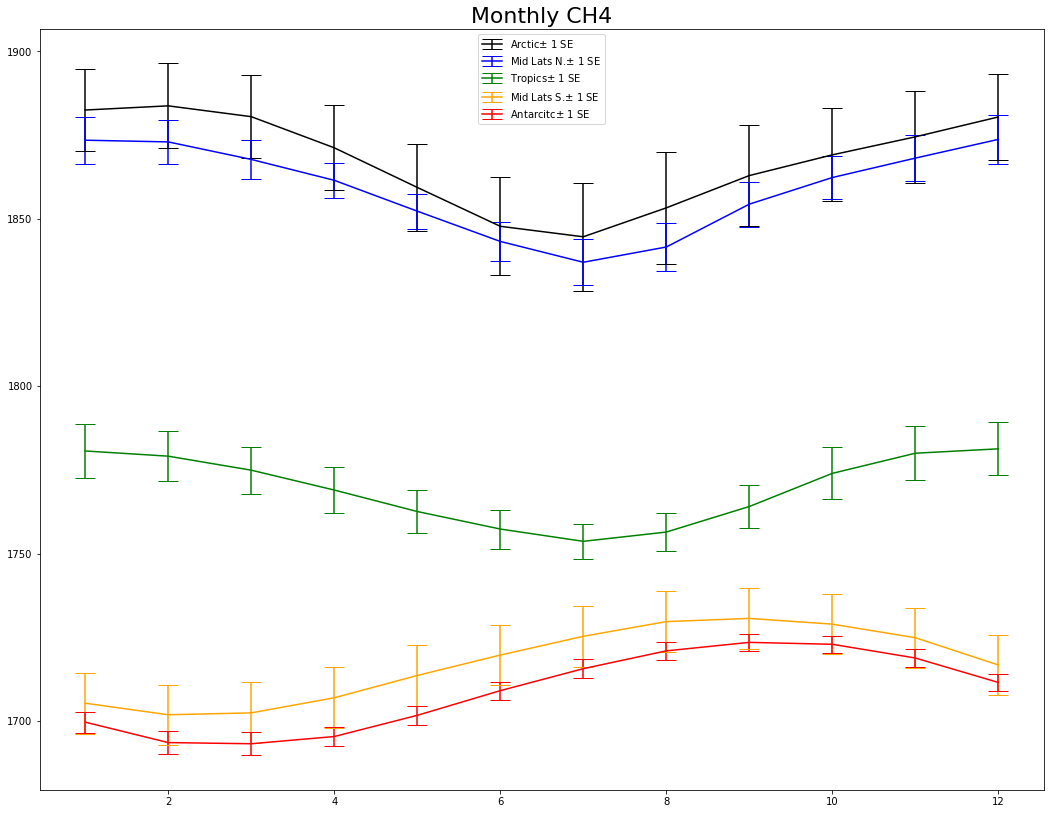

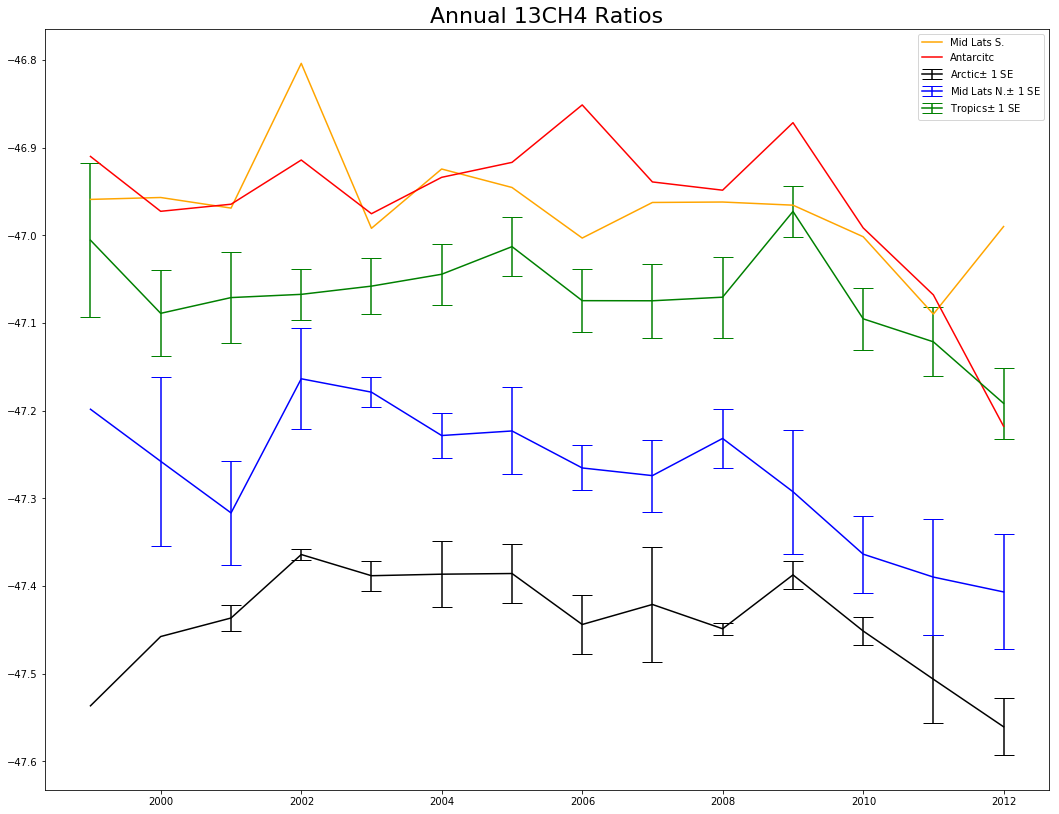

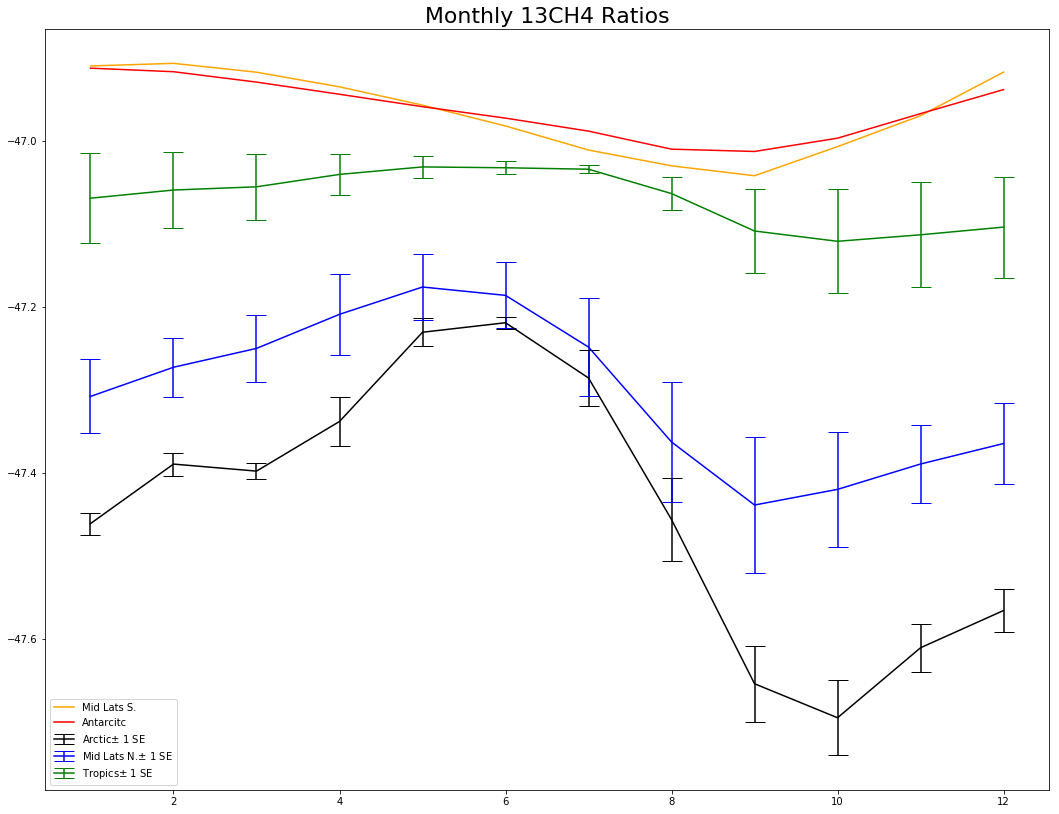

In [846]:

colors=['black','blue','green','orange','red']
labels=['Arctic','Mid Lats N.','Tropics','Mid Lats S.','Antarcitc']

Columns=[Arctic,Mid_Lats_N,Tropics,Mid_Lats_S,Antarctic]
title='Annual CH4'
Error_Bar_Plot(CH4.Yearly,Columns,colors,labels,title)

title='Monthly CH4'
Error_Bar_Plot(CH4.Monthly,Columns,colors,labels,title)

title='Annual 13CH4 Ratios'
Columns=[Arctic_13,Mid_Lats_N_13,Tropics_13,Mid_Lats_S_13,Antarctic_13]
Error_Bar_Plot(CH4_13.Yearly,Columns,colors,labels,title)

title='Monthly 13CH4 Ratios'
Error_Bar_Plot(CH4_13.Monthly,Columns,colors,labels,title)

(12, 181) (12,) (181, 1)


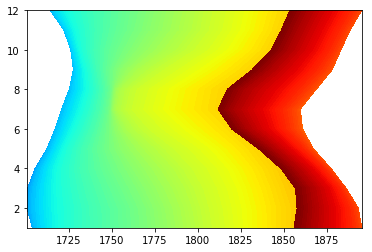

In [216]:
Lat_Profile,Lat_Profile_yr,Lat_Profile_mo = Profile(CH4)

kernel_CH4 = C(1e0, (1e-2, 1e2))*Matern(1e1, (1e-4, 1e4),nu = 2.5)\
+ WhiteKernel(noise_level=1e0, noise_level_bounds=(1e-2, 1e2))


# Preds = []
# for mo in range(Lat_Profile_mo.shape[1]):
#     key = np.where(np.isnan(Lat_Profile_mo['std'][:,mo])==False)
#     if len(key[0]) > 1: 
#         Lat,pred,sigma = Interp(Lat_Profile_mo[key[0],mo],kernel_CH4,alpha=0,plot=False)
#         Preds.append(pred)

# Preds = []
# for year in range(Lat_Profile_yr.shape[1]-1):
#     key = np.where(np.isnan(Lat_Profile_yr['std'][:,year])==False)
#     if len(key[0]) > 1: 
#         Lat,pred,sigma = Interp(Lat_Profile_yr[key[0],year],kernel_CH4,alpha=0,plot=False)
#         Preds.append(pred)
Surface = np.asanyarray(Preds)
Year = np.arange(1983,2017,1)
Year = np.arange(1,13,1)
X,Y = np.meshgrid(Lat,Year)

print(Surface.shape,Year.shape,Lat.shape)



# for pred in Preds:
#     plt.plot(pred,Lat)
# plt.imshow(Surface)
plt.pcolor(Surface,Y,X,cmap=cm.jet)#,aspect=5,cmap=cm.jet)
# Lat,pred,sigma = Interp(Lat_Profile,kernel_CH4,alpha=0,plot=False)
# Plot_Profile(Lat_Profile,pred,sigma,Surface,X,Y,Year,ax1_xlim=[1600,2015],azim=230)#,azim=230)
